# Sensitivity analysis on effect differences from FFT window size

This file generates and displays data for the within-study parameter sensitivity analysis.

In [1]:
# imports
import os
from functools import partial
from math import log
from pathlib import Path

from IPython.display import clear_output
import pandas as pd

import tools.plots as plts
from tools.index_sensitivity import IndexSensitivity
from tools.r_link import Rlink
from study_settings.big_vicky import BigVickySettings, BigVickyToolbox
from study_settings.carara import CararaSettings, CararaToolbox

/usr/lib/python3/dist-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
/usr/lib/python3/dist-packages/paramiko/transport.py:261: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# settings and r_link
r_link = Rlink()
r_link.capture_rpy2_output(errorwarn_callback=print)
r_link.load_src("tools/r_funcs.R")
indices_of_interest = ["ACI", "ADI", "AEI", "BIO"]
output_path = Path("./output")
# fft_window_sizes = [2**x for x in range(8, 13)] #6)]# + [22050, 48000]
plts.plt.rcParams.update({"font.size": 16})

In [3]:
def experiment(df:pd.DataFrame, group_to_process:tuple, toolbox:IndexSensitivity, r_link:Rlink, marine:bool, factors:list, cross_effect:str):
    '''
    Models and obtains conditional effects for every set of values in the dataframe. Sets are defined by grouping the "Index", "Filtered", and "Band" columns.
    This function is designed for use in this notebook and may not generalise well.

    df: dataframe of index values
    group_to_process: tuple with the multi-index of the group to model
    toolbox: an instance of the IndexSensitivity class, with settings relevant to the data and models
    r_link: an instance of the Rlink class
    marine: whether the data is from Big Vicky's (True) or Carara (False)
    factors: which columns to treat as factors
    cross_effect: which column is treated as the cross effect (along with Window)

    returns: a matplotlib figure of the model, and a table with the posterior effects summary
    '''
    samp_to_s = partial(toolbox.samples_to_s, toolbox.settings.sample_rate)
    s_to_samp = partial(toolbox.s_to_samples, toolbox.settings.sample_rate)
    conditional_effects = {}
    grouped_data = df.groupby(['Index', 'Filtered', 'Band'], observed=False)
    group = grouped_data.get_group(group_to_process).copy()
    index, filtered, band = group_to_process
    log_window = index != "AEI"
    if log_window:
        group["Window"] = group["Window"].apply(lambda x: log(x))

    if index not in conditional_effects:
        conditional_effects[index] = {True: {}, False: {}}

    txt = '_filtered' if filtered else ''
    trunc = group["Truncation"].unique().max()
    trunc = 0 if not trunc else trunc # rpy2 conversion issue
    flt = txt.replace('_', ' ')
    all_text = (index, flt, band, cross_effect)
    model, effects = toolbox.build_model(r_link, marine, all_text, group, factors, trunc)
    clear_output()
    print(model)
    filename = output_path / f"{cross_effect}_x_Window_conditional_effects_for_{index}_over{txt}_{band}_frequencies_Python"
    secax = ("Window duration (s)", (samp_to_s, s_to_samp))
    fig = plts.plot_conditional_effects(r_link,
                                    filename,
                                    effects,
                                    plot_points=True,
                                    sec_ax=secax,
                                    colors=toolbox.settings.colors,
                                    unlog=log_window)
    conditional_effects[index][filtered][band] = effects
    posterior_ratios = r_link.r_src.get_posterior_ratios(model, num=toolbox.settings.num, den=toolbox.settings.den, cross=cross_effect)
    posterior_effects = r_link.r_src.get_posterior_ratio_difference(posterior_ratios)

    warnings = r_link.r_src.get_warnings()
    if warnings != r_link.null_value:
        print(warnings)

    return fig, posterior_effects

In [4]:
# from tools.populate_ipynb import CellAdder
# print(CellAdder.generate_index_definitions())

In [5]:
# index definitions
broadband_ACI_group = ('ACI', False, 'broadband')
broadband_ADI_group = ('ADI', False, 'broadband')
broadband_AEI_group = ('AEI', False, 'broadband')
broadband_BIO_group = ('BIO', False, 'broadband')
fish_extracted_ACI_group = ('ACI', False, 'fish')
fish_extracted_ADI_group = ('ADI', False, 'fish')
fish_extracted_AEI_group = ('AEI', False, 'fish')
fish_extracted_BIO_group = ('BIO', False, 'fish')
fish_filtered_ACI_group = ('ACI', True, 'fish')
fish_filtered_ADI_group = ('ADI', True, 'fish')
fish_filtered_AEI_group = ('AEI', True, 'fish')
fish_filtered_BIO_group = ('BIO', True, 'fish')
shrimp_extracted_ACI_group = ('ACI', False, 'shrimp')
shrimp_extracted_ADI_group = ('ADI', False, 'shrimp')
shrimp_extracted_AEI_group = ('AEI', False, 'shrimp')
shrimp_extracted_BIO_group = ('BIO', False, 'shrimp')
shrimp_filtered_ACI_group = ('ACI', True, 'shrimp')
shrimp_filtered_ADI_group = ('ADI', True, 'shrimp')
shrimp_filtered_AEI_group = ('AEI', True, 'shrimp')
shrimp_filtered_BIO_group = ('BIO', True, 'shrimp')

## Carara

In [6]:
# settings and frequency bands
carara_settings = CararaSettings
carara_settings.data_location = os.path.expanduser(carara_settings.data_location)
test_bands = [("broadband", (0, carara_settings.max_freq), False)]
fft_window_sizes = [2**x for x in range(8, 15)] + [22050]


In [7]:
carara_toolbox = CararaToolbox(carara_settings, fft_window_sizes, test_bands, indices_of_interest)

In [8]:
carara_index_values = carara_toolbox.get_index_values(output_file="output/terrestrial_index_values")

In [9]:
carara_df = carara_toolbox.create_dataframe(carara_index_values, output_path="output/terrestrial_dataframe.pkl")

### Carara - broadband ACI


In [10]:
carara_broadband_ACI_fig, carara_broadband_ACI_ratio_summary = experiment(carara_df,
          broadband_ACI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2288) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.47      0.22     0.21     1.09 1.00     3908     2717

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.95      0.22    -1.42    -0.48 1.00     4050     2702
SiteIR            0.12      0.02     0.09     0.16 1.00     9999    11570
Window            1.03      0.00     1.03     1.03 1.00    12940    14485
SiteIR:Window    -0.02      0.00    -0.02    -0.01 1.00    10018    11751

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   181.47      5.44   171.05   192.36

In [11]:
print(carara_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.08 0.0102



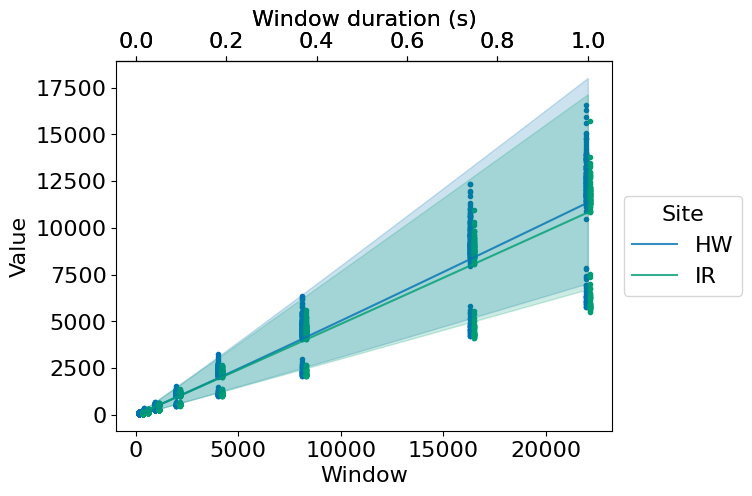

In [12]:
carara_broadband_ACI_fig


### Carara - broadband ADI


In [13]:
carara_broadband_ADI_fig, carara_broadband_ADI_ratio_summary = experiment(carara_df,
          broadband_ADI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2288) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.07      0.04     0.03     0.19 1.00     4478     2944

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.25      0.05     1.14     1.34 1.00     7099     6350
SiteIR            0.02      0.06    -0.10     0.14 1.00     8815     7521
Window           -0.03      0.00    -0.04    -0.02 1.00    11643     8421
SiteIR:Window     0.01      0.01    -0.01     0.02 1.00     8697     7637

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape    15.08      0.44    14.24    15.95

In [14]:
print(carara_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.04 0.0270



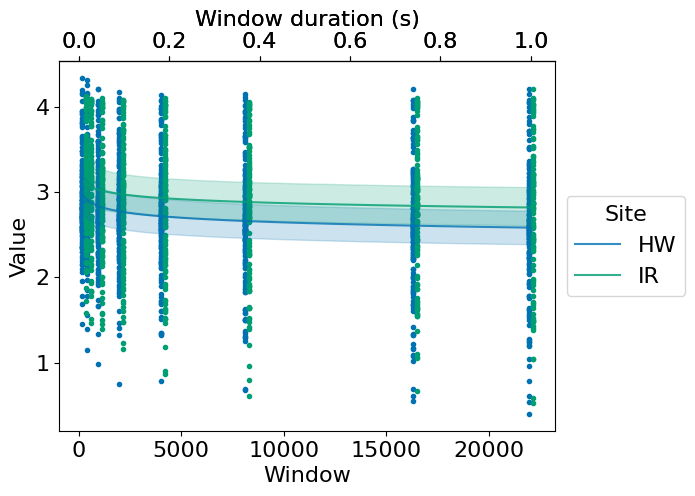

In [15]:
carara_broadband_ADI_fig


### Carara - broadband AEI


In [16]:
carara_broadband_AEI_fig, carara_broadband_AEI_ratio_summary = experiment(carara_df,
          broadband_AEI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2288) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.19      0.18     0.07     0.53 1.00     2085     2013

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.70      0.11     1.49     1.90 1.00     1632     1806
SiteIR           -0.24      0.04    -0.33    -0.17 1.00     7772    12204
Window            0.00      0.00     0.00     0.00 1.00    20593    19689
SiteIR:Window    -0.00      0.00    -0.00     0.00 1.00    15094    19292

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    14.09      0.42    13.28    14.93 1.00

In [17]:
print(carara_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00785



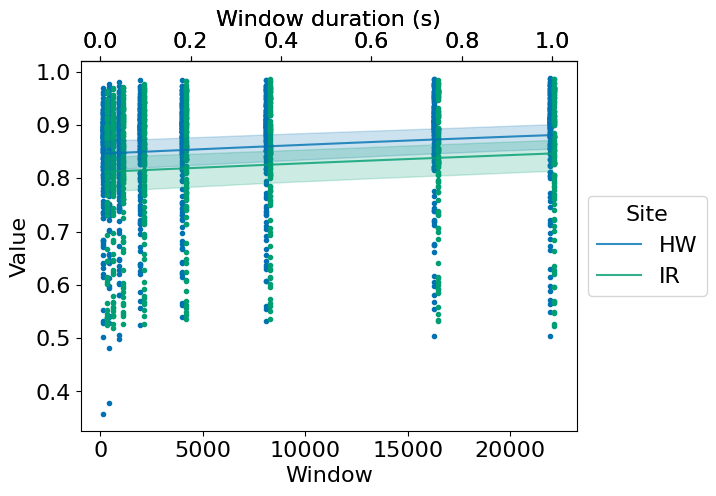

In [18]:
carara_broadband_AEI_fig


### Carara - broadband BIO


In [19]:
carara_broadband_BIO_fig, carara_broadband_BIO_ratio_summary = experiment(carara_df,
          broadband_BIO_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2288) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.95      0.43     0.43     2.12 1.00     4809     5736

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.19      0.44    -9.11    -7.29 1.00     5246     6420
SiteIR           -0.30      0.08    -0.46    -0.14 1.00     9645    11746
Window            2.03      0.01     2.02     2.04 1.00    11998    14793
SiteIR:Window     0.00      0.01    -0.02     0.02 1.00     9584    11623

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     8.06      0.23     7.61     8.53

In [20]:
print(carara_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.04 0.0305



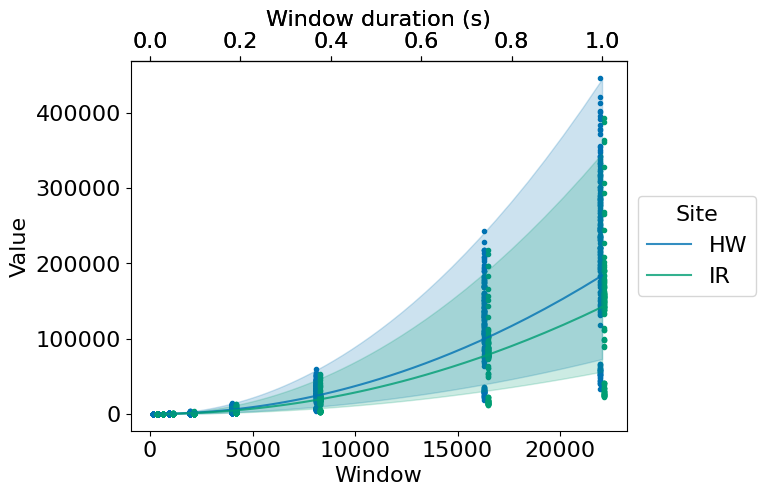

In [21]:
carara_broadband_BIO_fig


## Big Vicky

In [22]:
# settings and frequency bands
vicky_settings = BigVickySettings
vicky_settings.data_location = os.path.expanduser(vicky_settings.data_location)
test_bands = [("broadband", (100, vicky_settings.sample_rate), False),
              ("shrimp", vicky_settings.shrimp_frequencies, False),
              ("shrimp", vicky_settings.shrimp_frequencies, True),
              ("fish", vicky_settings.fish_frequencies, False),
              ("fish", vicky_settings.fish_frequencies, True)]

fft_window_sizes = [2**x for x in range(8, 16)] + [48000]

In [23]:
vicky_toolbox = BigVickyToolbox(vicky_settings, fft_window_sizes, test_bands, indices_of_interest)

In [24]:
vicky_index_values = vicky_toolbox.get_index_values(output_file="output/vicky_index_values.pkl")

In [25]:
vicky_df = vicky_toolbox.create_dataframe(vicky_index_values, output_path="output/vicky_dataframe.pkl")

### Big Vicky - broadband ACI


In [26]:
vicky_extracted_broadband_ACI_fig, vicky_extracted_broadband_ACI_ratio_summary = experiment(vicky_df,
          broadband_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.06      0.01     0.05     0.08 1.00     2165     3852

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.34      0.01     0.32     0.37 1.00     1486     2705
Hour12           -0.09      0.01    -0.11    -0.08 1.00     6569     8571
Window            0.92      0.00     0.92     0.92 1.00     8531    11559
Hour12:Window     0.02      0.00     0.02     0.02 1.00     6595     8634

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   406.96      8.28   390.98   423

In [27]:
print(vicky_extracted_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00463



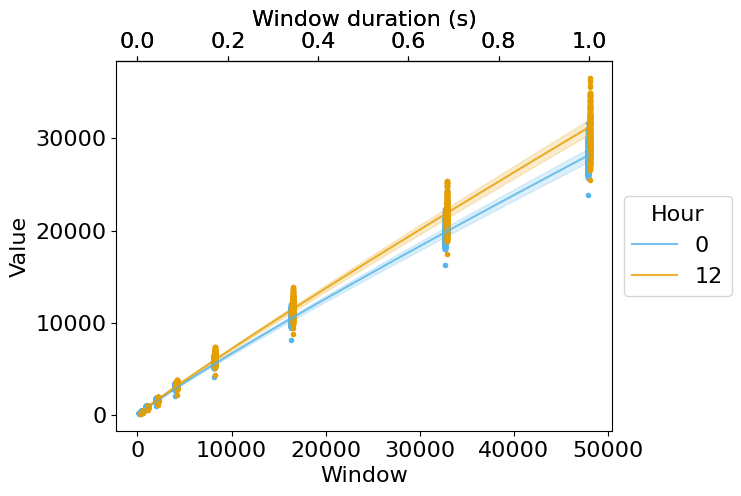

In [28]:
vicky_extracted_broadband_ACI_fig


### Big Vicky - extracted fish ACI


In [29]:
vicky_extracted_fish_ACI_fig, vicky_extracted_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.05      0.01     0.03     0.06 1.00     2191     4518

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -3.64      0.01    -3.67    -3.62 1.00     2654     4771
Hour12           -0.16      0.01    -0.19    -0.14 1.00     7007    10862
Window            0.97      0.00     0.97     0.97 1.00     9001    13225
Hour12:Window     0.02      0.00     0.01     0.02 1.00     6980    10771

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   141.26      2.85   135.75   146

In [30]:
print(vicky_extracted_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.09 0.00799



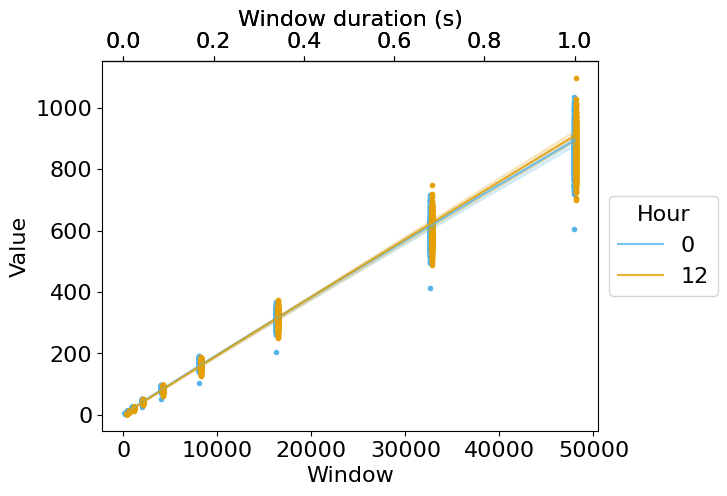

In [31]:
vicky_extracted_fish_ACI_fig


### Big Vicky - extracted shrimp ACI


In [32]:
vicky_extracted_shrimp_ACI_fig, vicky_extracted_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.04      0.01     0.03     0.06 1.00     2131     3813

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.67      0.01    -1.69    -1.65 1.00     2072     4294
Hour12           -0.14      0.01    -0.16    -0.13 1.00     6363     8966
Window            0.92      0.00     0.92     0.92 1.00     8498    12416
Hour12:Window     0.03      0.00     0.02     0.03 1.00     6380     8786

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   281.64      5.72   270.55   292

In [33]:
print(vicky_extracted_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.14 0.00589



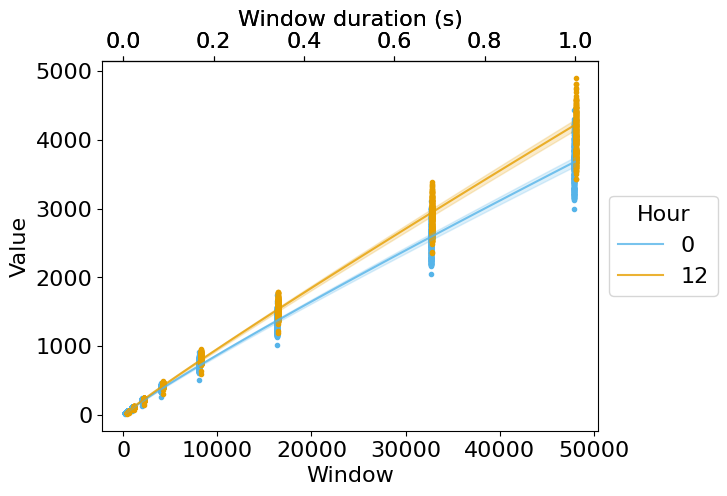

In [34]:
vicky_extracted_shrimp_ACI_fig


### Big Vicky - filtered fish ACI


In [35]:
vicky_filtered_fish_ACI_fig, vicky_filtered_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.01     0.01 1.00     2460     4974

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.50      0.00    -0.51    -0.50 1.00     3494     6908
Hour12           -0.01      0.00    -0.01     0.00 1.00    12725    15328
Window            0.99      0.00     0.99     0.99 1.00    15774    18457
Hour12:Window     0.00      0.00     0.00     0.00 1.00    12975    15712

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  2251.00     44.99  2164.04  2339

In [36]:
print(vicky_filtered_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00181



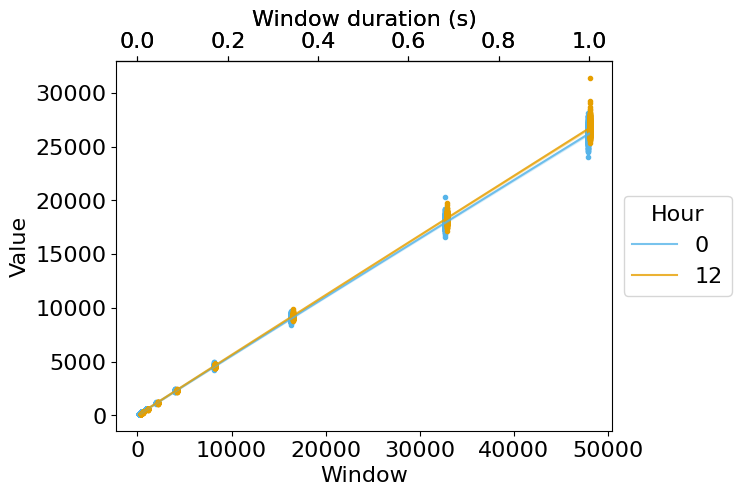

In [37]:
vicky_filtered_fish_ACI_fig


### Big Vicky - filtered shrimp ACI


In [38]:
vicky_filtered_shrimp_ACI_fig, vicky_filtered_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.01     0.03 1.01     1880     3940

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.27      0.00    -0.27    -0.26 1.00     2419     4673
Hour12           -0.04      0.00    -0.05    -0.04 1.00     8402    10756
Window            0.97      0.00     0.97     0.97 1.00    13335    16410
Hour12:Window     0.01      0.00     0.01     0.01 1.00     8522    11317

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1484.68     29.79  1426.83  1543

In [39]:
print(vicky_filtered_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.05 0.00236



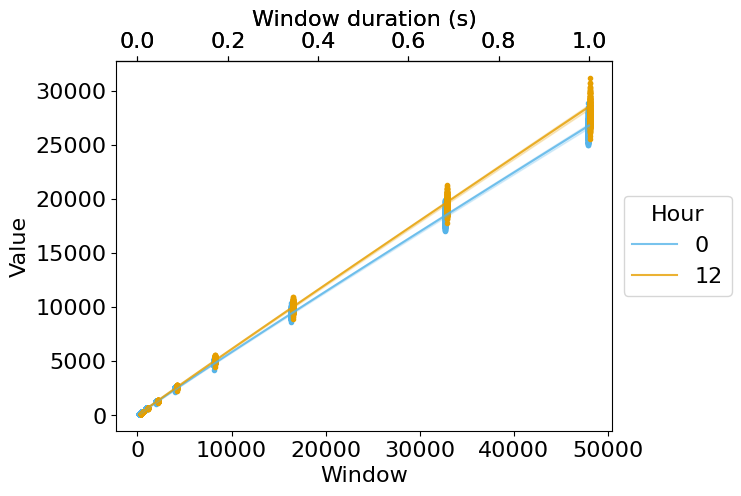

In [40]:
vicky_filtered_shrimp_ACI_fig


### Big Vicky - broadband ADI


In [41]:
vicky_extracted_broadband_ADI_fig, vicky_extracted_broadband_ADI_ratio_summary = experiment(vicky_df,
          broadband_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.02     0.03 1.00     2822     5076

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.55      0.01     1.53     1.56 1.00     3739     8328
Hour12            0.10      0.01     0.09     0.12 1.00    10273    13336
Window            0.01      0.00     0.00     0.01 1.00    14582    16127
Hour12:Window    -0.01      0.00    -0.01    -0.01 1.00    10371    12927

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   348.71      7.10   335.02   362

In [42]:
print(vicky_extracted_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.07 0.00488



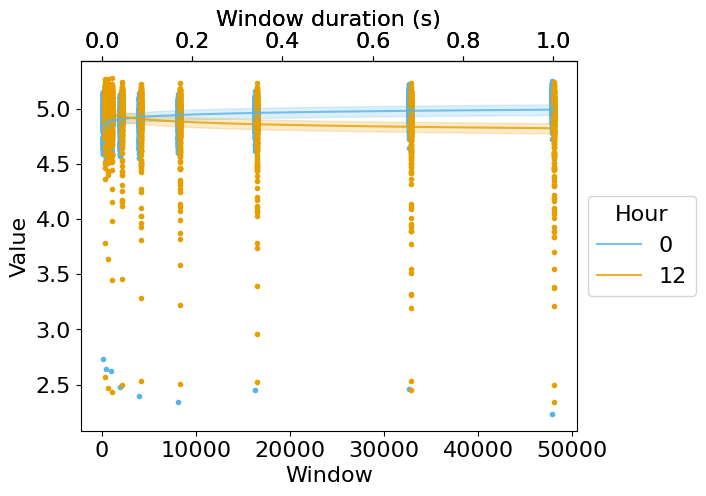

In [43]:
vicky_extracted_broadband_ADI_fig


### Big Vicky - extracted fish ADI


In [44]:
vicky_extracted_fish_ADI_fig, vicky_extracted_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.03      0.01     0.02     0.04 1.00     3929     5887

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.08      0.01    -0.10    -0.05 1.00     6442    11825
Hour12            0.02      0.01    -0.01     0.04 1.00    11558    14835
Window            0.05      0.00     0.05     0.06 1.00    14695    17919
Hour12:Window    -0.01      0.00    -0.01    -0.00 1.00    11494    14474

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   103.52      2.09    99.47   107

In [45]:
print(vicky_extracted_fish_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.04 0.00890



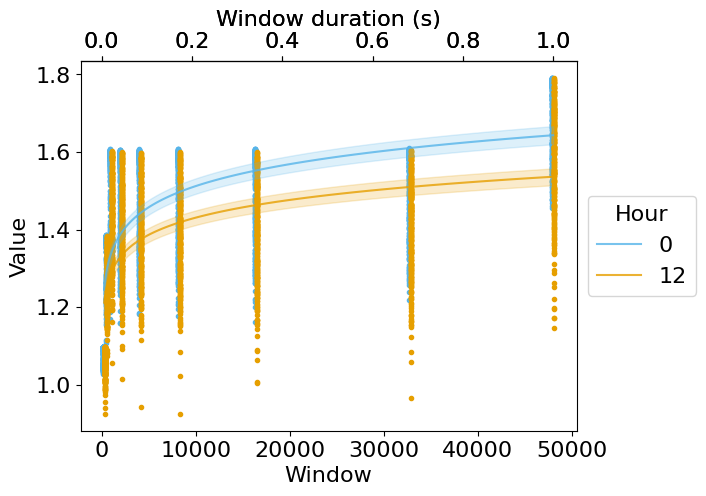

In [46]:
vicky_extracted_fish_ADI_fig


### Big Vicky - extracted shrimp ADI


In [47]:
vicky_extracted_shrimp_ADI_fig, vicky_extracted_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.00      0.00     0.00     0.00 1.00     6704    10561

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.18      0.00     1.18     1.18 1.00    16603    19220
Hour12            0.01      0.00     0.00     0.01 1.00    36437    18961
Window            0.00      0.00     0.00     0.00 1.00    29911    21645
Hour12:Window    -0.00      0.00    -0.00    -0.00 1.00    35047    19281

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  5059.79    102.00  4863.37  5261

In [48]:
print(vicky_extracted_shrimp_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.00 0.00121



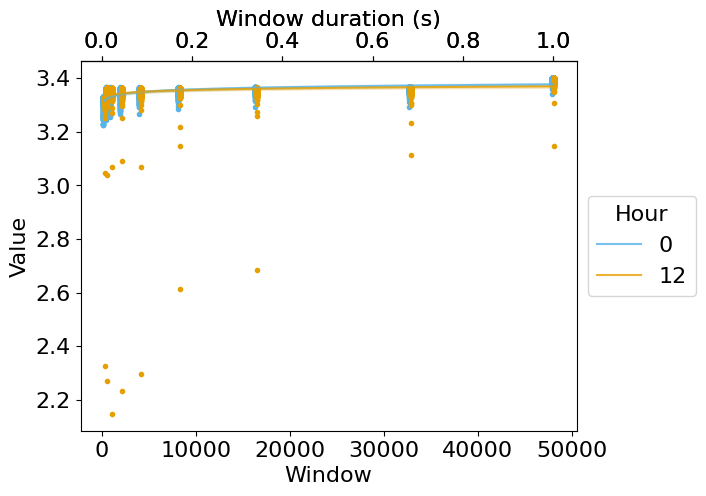

In [49]:
vicky_extracted_shrimp_ADI_fig


### Big Vicky - filtered fish ADI


In [50]:
vicky_filtered_fish_ADI_fig, vicky_filtered_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.03      0.00     0.02     0.04 1.00     2665     4409

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.75      0.01     0.73     0.77 1.00     2492     4500
Hour12           -0.07      0.01    -0.09    -0.06 1.00     8429    11728
Window           -0.01      0.00    -0.01    -0.01 1.00    11521    16275
Hour12:Window    -0.00      0.00    -0.00    -0.00 1.00     8548    11948

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   382.94      7.72   367.89   398

In [51]:
print(vicky_filtered_fish_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00441



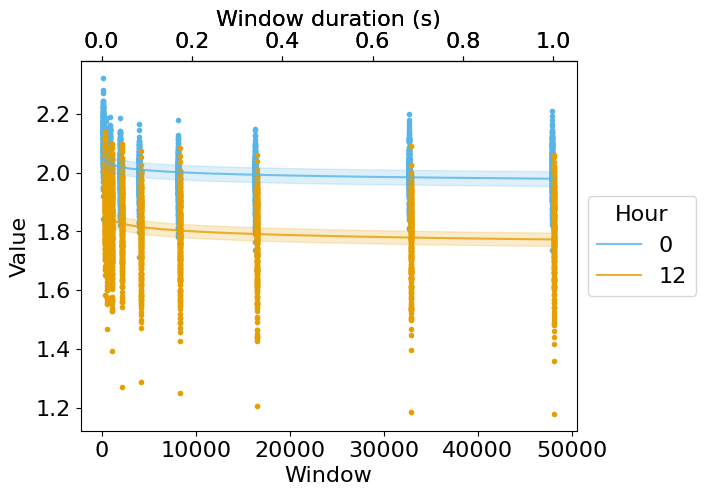

In [52]:
vicky_filtered_fish_ADI_fig


### Big Vicky - filtered shrimp ADI


In [53]:
vicky_filtered_shrimp_ADI_fig, vicky_filtered_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.00     0.01 1.00     3241     4676

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.24      0.00     1.24     1.24 1.00     5440    10833
Hour12            0.03      0.00     0.02     0.03 1.00    17084    15813
Window            0.00      0.00     0.00     0.00 1.00    19910    18254
Hour12:Window    -0.00      0.00    -0.00    -0.00 1.00    17342    16245

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  4218.72     85.87  4052.79  4390

In [54]:
print(vicky_filtered_shrimp_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00132



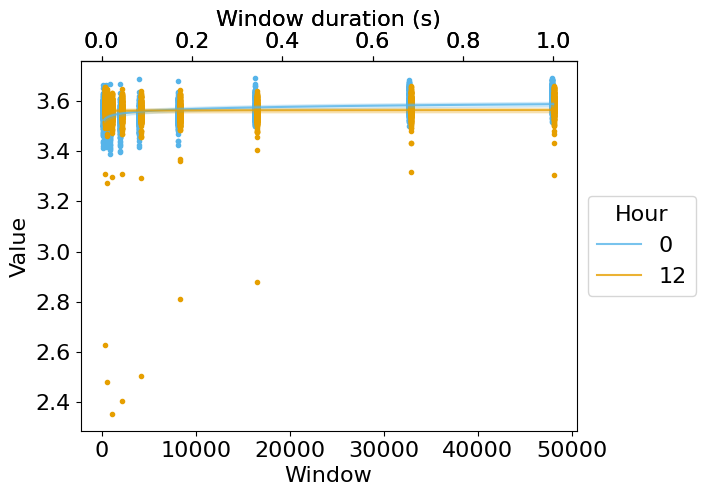

In [55]:
vicky_filtered_shrimp_ADI_fig


### Big Vicky - broadband AEI


In [56]:
vicky_extracted_broadband_AEI_fig, vicky_extracted_broadband_AEI_ratio_summary = experiment(vicky_df,
          broadband_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.73      0.20     0.35     1.03 3.00        6       11

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.28      0.05     0.20     0.35 2.90        6       16
Hour12           -0.18      0.01    -0.20    -0.16 1.04      131      289
Window           -0.00      0.00    -0.00    -0.00 1.01      679     2658
Hour12:Window     0.00      0.00     0.00     0.00 1.01      346     1190

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    56.54      1.17    54.35    58.72 1

In [57]:
print(vicky_extracted_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.32 0.0173



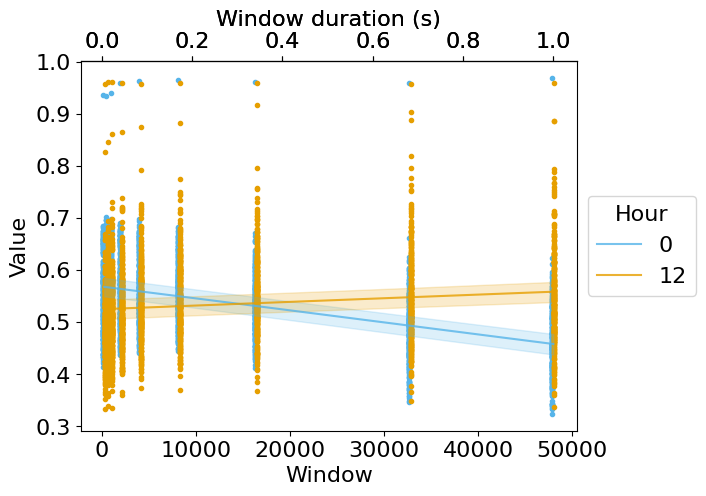

In [58]:
vicky_extracted_broadband_AEI_fig


### Big Vicky - extracted fish AEI


In [59]:
vicky_extracted_fish_AEI_fig, vicky_extracted_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.24      0.04     0.18     0.32 1.04      106      258

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.42      0.05    -1.50    -1.32 1.25       15       28
Hour12            0.40      0.02     0.35     0.45 1.00      766     1315
Window            0.00      0.00     0.00     0.00 1.00     3383     7990
Hour12:Window     0.00      0.00     0.00     0.00 1.00     1964     4813

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    11.62      0.23    11.19    12.09 1

In [60]:
print(vicky_extracted_fish_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.09 0.0420



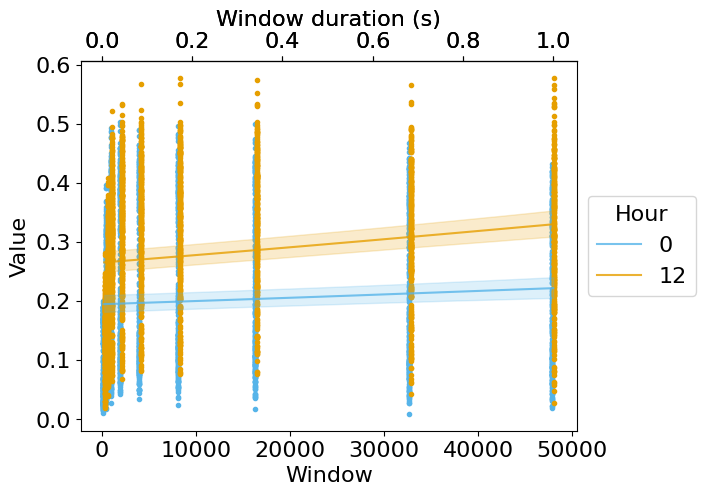

In [61]:
vicky_extracted_fish_AEI_fig


### Big Vicky - extracted shrimp AEI


In [62]:
vicky_extracted_shrimp_AEI_fig, vicky_extracted_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.30      0.09     0.19     0.55 2.09        7       18

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -2.06      0.08    -2.18    -1.92 2.94        6       11
Hour12           -0.17      0.01    -0.20    -0.15 1.02      251      431
Window           -0.00      0.00    -0.00    -0.00 1.01     1513     6746
Hour12:Window     0.00      0.00     0.00     0.00 1.01      798     2358

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    75.71      1.61    72.64    78.94 1

In [63]:
print(vicky_extracted_shrimp_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.94 0.0668



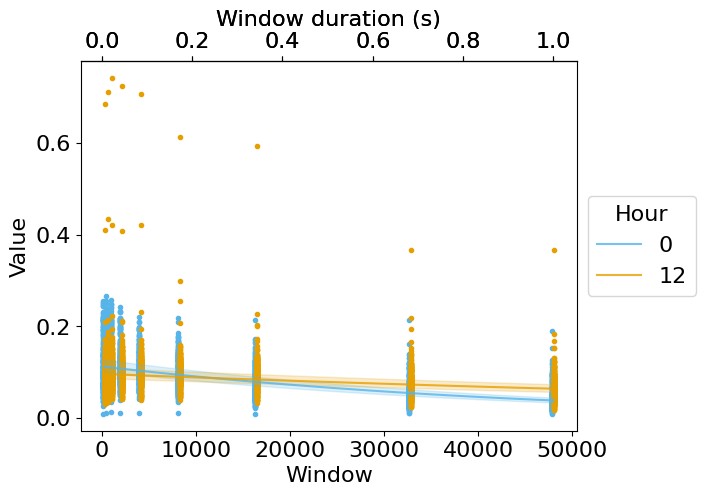

In [64]:
vicky_extracted_shrimp_AEI_fig


### Big Vicky - filtered fish AEI


In [65]:
vicky_filtered_fish_AEI_fig, vicky_filtered_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.02      0.04     0.95     1.08 2.92        6       12

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         3.64      0.01     3.63     3.65 1.95        7       25
Hour12            0.20      0.00     0.20     0.21 1.17       23       55
Window            0.00      0.00    -0.00     0.00 1.02      205     1790
Hour12:Window     0.00      0.00     0.00     0.00 1.05       80      364

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi  3659.08     63.13  3547.99  3789.09 1

In [66]:
print(vicky_filtered_fish_AEI_ratio_summary)


# A tibble: 1 × 2
   mean       sd
  <dbl>    <dbl>
1  1.00 0.000204



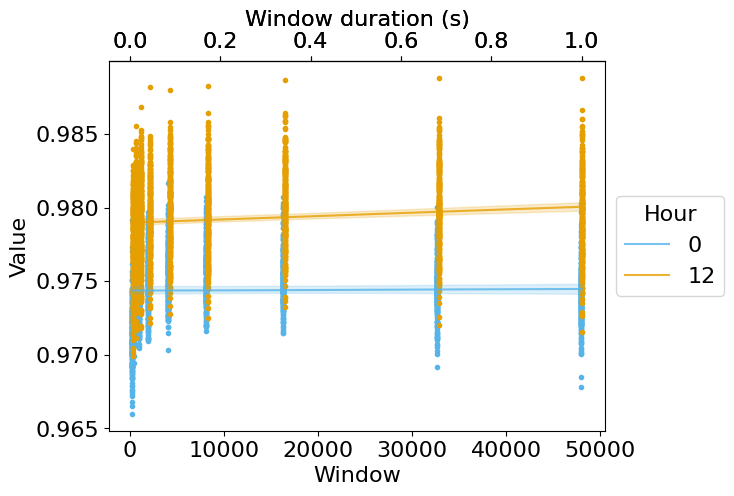

In [67]:
vicky_filtered_fish_AEI_fig


### Big Vicky - filtered shrimp AEI


In [68]:
vicky_filtered_shrimp_AEI_fig, vicky_filtered_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.01      0.02     0.99     1.05 4.00        5       13

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.97      0.00     1.97     1.98 2.12        7       30
Hour12           -0.03      0.00    -0.04    -0.03 1.64        8       24
Window           -0.00      0.00    -0.00    -0.00 1.10       29      123
Hour12:Window     0.00      0.00     0.00     0.00 1.21       16       60

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi  2238.70     91.81  2072.86  2401.80 2

In [69]:
print(vicky_filtered_shrimp_AEI_ratio_summary)


# A tibble: 1 × 2
   mean       sd
  <dbl>    <dbl>
1  1.01 0.000776



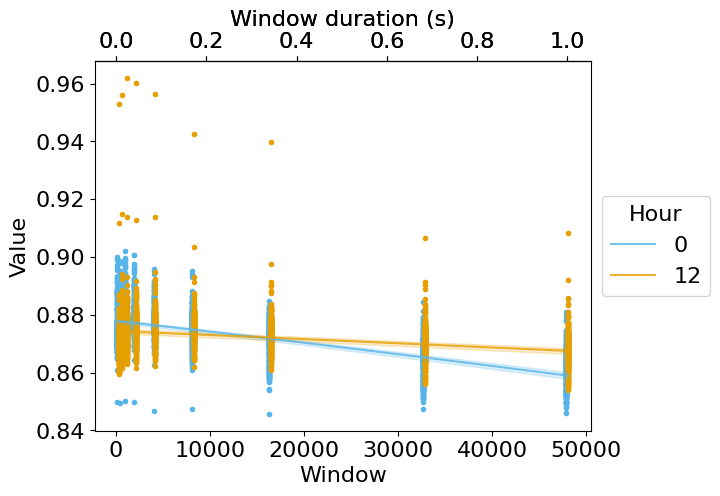

In [70]:
vicky_filtered_shrimp_AEI_fig


### Big Vicky - broadband BIO


In [71]:
vicky_extracted_broadband_BIO_fig, vicky_extracted_broadband_BIO_ratio_summary = experiment(vicky_df,
          broadband_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.15      0.02     0.11     0.20 1.00     1610     2433

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.37      0.03    -8.44    -8.31 1.00     1494     2126
Hour12            0.01      0.01    -0.01     0.04 1.00     4358     6998
Window            2.03      0.00     2.03     2.03 1.00     5358     8234
Hour12:Window    -0.02      0.00    -0.02    -0.02 1.00     4333     7067

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   131.56      2.61   126.42   136

In [72]:
print(vicky_extracted_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00819



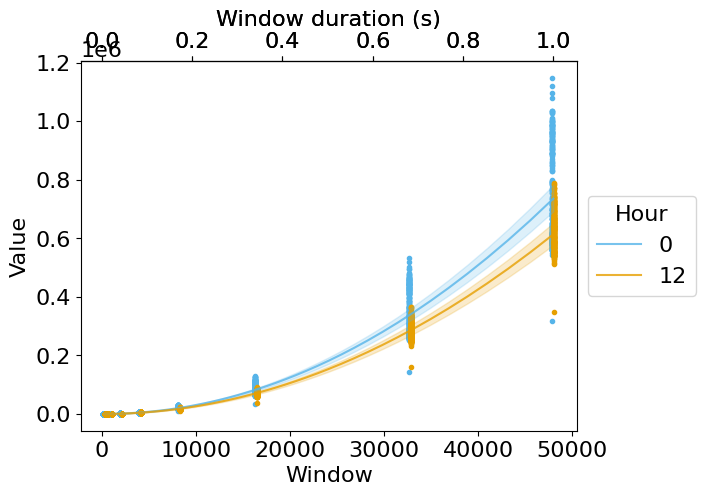

In [73]:
vicky_extracted_broadband_BIO_fig


### Big Vicky - extracted fish BIO


In [74]:
vicky_extracted_fish_BIO_fig, vicky_extracted_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.31      0.05     0.24     0.42 1.00     2191     4157

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -14.59      0.08   -14.74   -14.43 1.00     2651     4319
Hour12            0.26      0.06     0.14     0.38 1.00     6281     9328
Window            2.18      0.01     2.17     2.19 1.00     7382     9988
Hour12:Window    -0.05      0.01    -0.06    -0.03 1.00     6263     9100

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     5.44      0.11     5.24     5

In [75]:
print(vicky_extracted_fish_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.28 0.0487



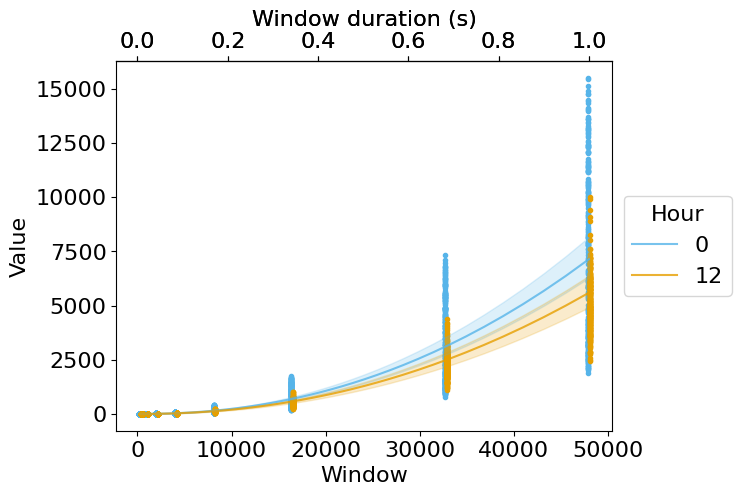

In [76]:
vicky_extracted_fish_BIO_fig


### Big Vicky - extracted shrimp BIO


In [77]:
vicky_extracted_shrimp_BIO_fig, vicky_extracted_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.23      0.04     0.17     0.31 1.00     2078     3532

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -13.01      0.05   -13.10   -12.91 1.01     1777     3130
Hour12            0.06      0.03     0.01     0.11 1.00     4829     7334
Window            2.09      0.00     2.09     2.09 1.00     5539     8679
Hour12:Window     0.01      0.00    -0.00     0.01 1.00     4787     7313

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape    28.41      0.57    27.31    29

In [78]:
print(vicky_extracted_shrimp_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.03 0.0161



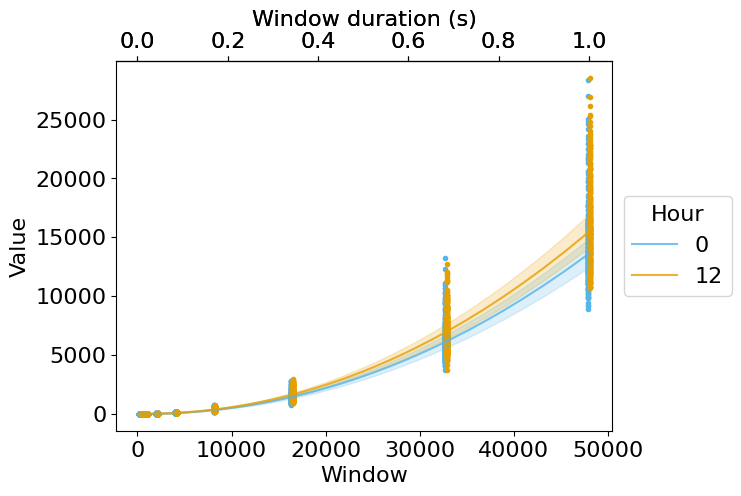

In [79]:
vicky_extracted_shrimp_BIO_fig


### Big Vicky - filtered fish BIO


In [80]:
vicky_filtered_fish_BIO_fig, vicky_filtered_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.02     0.03 1.00     1857     3569

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -9.13      0.01    -9.14    -9.12 1.00     1809     3321
Hour12            0.01      0.00     0.01     0.02 1.00     7001     9763
Window            2.07      0.00     2.06     2.07 1.00    11711    15235
Hour12:Window    -0.01      0.00    -0.01    -0.01 1.00     7082     9610

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1409.93     28.08  1355.09  1465

In [81]:
print(vicky_filtered_fish_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.06 0.00242



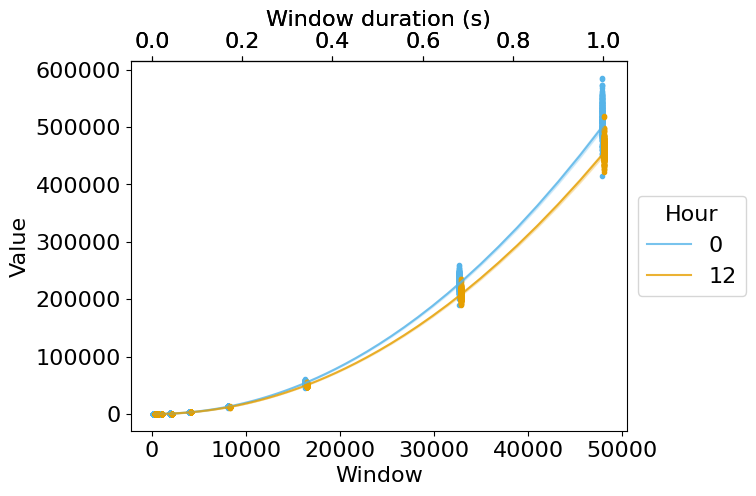

In [82]:
vicky_filtered_fish_BIO_fig


### Big Vicky - filtered shrimp BIO


In [83]:
vicky_filtered_shrimp_BIO_fig, vicky_filtered_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 4977) 
  Draws: 5 chains, each with iter = 20000; warmup = 15000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.01     0.02 1.00     2265     4030

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.67      0.00    -8.68    -8.67 1.00     2574     5564
Hour12           -0.01      0.00    -0.02     0.00 1.00    11497    13461
Window            2.10      0.00     2.10     2.10 1.00    15553    17971
Hour12:Window     0.00      0.00     0.00     0.00 1.00    11647    14006

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1136.71     22.99  1091.42  1181

In [84]:
print(vicky_filtered_shrimp_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00254



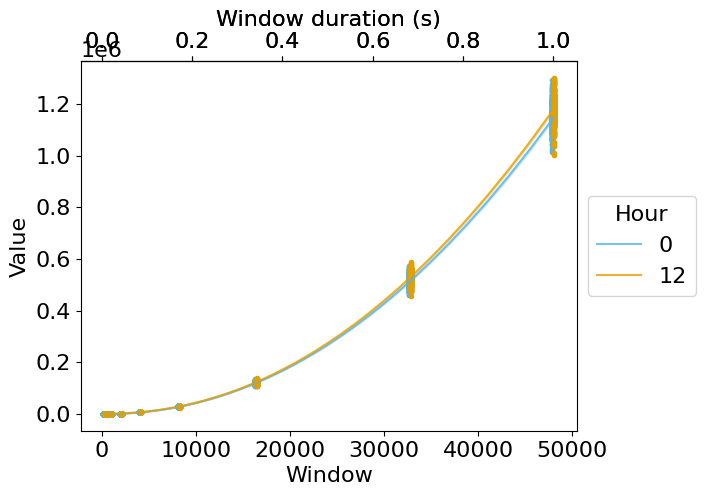

In [85]:
vicky_filtered_shrimp_BIO_fig
